### Working with multiple time series where the files are to big to fit more than one into memory at a time

This notebook is my work interspersed with an orginal Darts notebook 

In [1]:
# fix python path if working locally
from utils import fix_pythonpath_if_working_locally

fix_pythonpath_if_working_locally()

import logging

import matplotlib.pyplot as plt
import numpy as np
import torch

from darts import concatenate
from darts.dataprocessing.transformers import Scaler
from darts.datasets import AirPassengersDataset, ElectricityDataset, MonthlyMilkDataset
from darts.metrics import mae, mape
from darts.models import (
    VARIMA,
    BlockRNNModel,
    NBEATSModel,
    RNNModel,
)
from darts.utils.callbacks import TFMProgressBar
from darts.utils.timeseries_generation import (
    datetime_attribute_timeseries,
    sine_timeseries,
)
from pytorch_lightning.callbacks.early_stopping import EarlyStopping

logging.disable(logging.CRITICAL)

import warnings

warnings.filterwarnings("ignore")

%matplotlib inline

# for reproducibility
torch.manual_seed(1)
np.random.seed(1)


def generate_torch_kwargs():
    # run torch models on CPU, and disable progress bars for all model stages except training.
    return {
        "pl_trainer_kwargs": {
            "accelerator": "cpu",
            "callbacks": [TFMProgressBar(enable_train_bar_only=True)],
        }
    }

### Read Data
Let's start by reading two time series - one containing the monthly number of air passengers, and another containing the monthly milk production per cow. These time series have not much to do with each other, except that they both have a monthly frequency with a marked yearly periodicity and upward trend, and (completely coincidentaly) they contain values of a comparable order of magnitude.

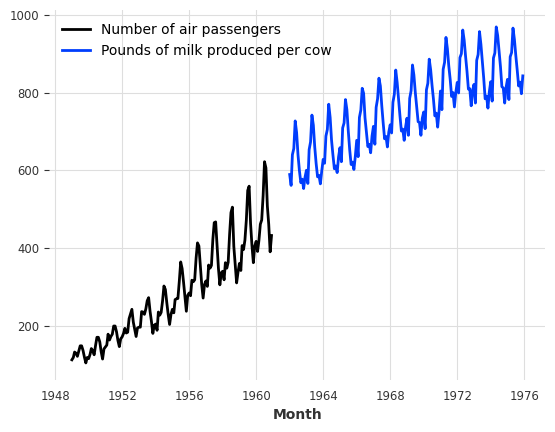

In [3]:
series_air = AirPassengersDataset().load()
series_milk = MonthlyMilkDataset().load()

series_air.plot(label="Number of air passengers")
series_milk.plot(label="Pounds of milk produced per cow")
plt.legend();

### Preprocessing
Usually neural networks tend to work better on normalised/standardised data. Here we'll use the `Scaler` class to normalise both of our time series between 0 and 1:

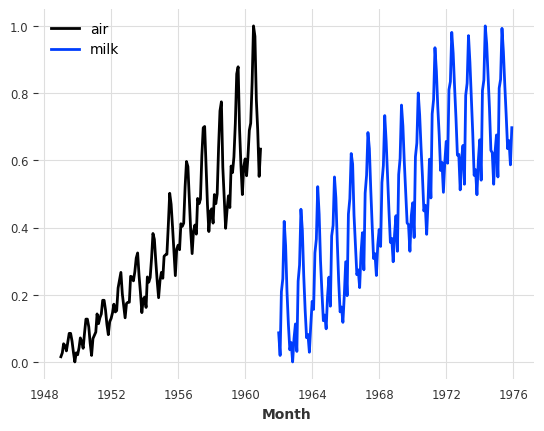

In [4]:
scaler_air, scaler_milk = Scaler(), Scaler()
series_air_scaled = scaler_air.fit_transform(series_air)
series_milk_scaled = scaler_milk.fit_transform(series_milk)

series_air_scaled.plot(label="air")
series_milk_scaled.plot(label="milk")
plt.legend();

### Train / Validation split
Let's keep the last 36 months of both series as validation:

In [5]:
train_air, val_air = series_air_scaled[:-36], series_air_scaled[-36:]
train_milk, val_milk = series_milk_scaled[:-36], series_milk_scaled[-36:]

### Training Process (behind the scenes)
So what happened when we called `model_air.fit()` above?

In order to train the internal neural network, Darts first makes a dataset of inputs/outputs examples from the provided time series (in this case: `series_air_scaled`). There are several ways this can be done and Darts contains a few different dataset implementations in the `darts.utils.data` package. 

By default, `NBEATSModel` will instantiate a `darts.utils.data.PastCovariatesSequentialDataset`, which simply builds all the consecutive pairs of input/output sub-sequences (of lengths `input_chunk_length` and `output_chunk_length`) existing in the series).

For an example series of length 14, with `input_chunk_length=4` and `output_chunk_length=2`, it looks as follows:
![](static/images/seq_dataset_one_ts.png)

For such a dataset, a series of length `N` would result in a "training set" of `N - input_chunk_length - output_chunk_length + 1` samples. In the toy example above, we have `N=14`, `input_chunk_length=4` and `output_chunk_length=2`, so the number of samples used for training would be K = 9. In this context, a training *epoch* consists in complete pass (possibly consisting of several mini-batches) over all the samples.

Note that different models are susceptible to use different datasets by default. For instance, `darts.utils.data.HorizonBasedDataset` is inspired by the [N-BEATS paper](https://arxiv.org/abs/1905.10437) and produces samples that are "close" to the end of the series, possibly even ignoring the beginning of the series.

If you have the need to control the way training samples are produced from `TimeSeries` instances, you can implement your own training dataset by inheriting the abstract `darts.utils.data.TrainingDataset` class. Darts datasets are inheriting from torch `Dataset`, which means it's easy to implement lazy versions that do not load all data in memory at once. Once you have your own instance of a dataset, you can directly call the `fit_from_dataset()` method, which is supported by all global forecasting models.

## Training a Model on Multiple Time Series
All this machinery can be seamlessly used with multiple time series. Here's how a sequential dataset with `input_chunk_length=4` and `output_chunk_length=2` looks for two series of lengths N and M:

![](static/images/seq_dataset_multi_ts.png)

Note a few things here:

* The different series do not need to have the same length, or even to share the same time stamps.
* In fact, they don't even need to have the same frequency.
* The total number of samples in the training dataset will be the union of all the training samples contained in each series; so a training epoch will now span all samples from all series.


### Training on Both Air Traffic and Milk Series
Let's look at another example where we fit another model instance on our two time series (air passengers and milk production). Since using two series of (roughly) the same length (roughly) doubles the training dataset size, we will use half of the number of epochs:

In [23]:
model_air_milk = NBEATSModel(
    input_chunk_length=24,
    output_chunk_length=12,
    n_epochs=114,
    optimizer_kwargs={"lr": 1e-4},
    random_state=0,
    log_tensorboard=True,
    model_name="air_milk",
    **generate_torch_kwargs(),
)

Then, fitting the model on two (or more) series is as simple as giving a list of series (instead of a single series) in argument to the `fit()` function:

In [24]:
model_air_milk.fit([train_air, train_milk], val_series=val_air, verbose=True)

Training: 0it [00:00, ?it/s]

NBEATSModel(output_chunk_shift=0, generic_architecture=True, num_stacks=30, num_blocks=1, num_layers=4, layer_widths=256, expansion_coefficient_dim=5, trend_polynomial_degree=2, dropout=0.0, activation=ReLU, input_chunk_length=24, output_chunk_length=12, n_epochs=114, optimizer_kwargs={'lr': 0.0001}, random_state=0, log_tensorboard=True, model_name=air_milk, pl_trainer_kwargs={'accelerator': 'cpu', 'callbacks': [<darts.utils.callbacks.TFMProgressBar object at 0x7fbab34365c0>]})

### Producing Forecasts After the End of a Series

Now, importantly, when computing the forecasts we have to specify which time series we want to forecast the future for.

We didn't have this constraint earlier. When fitting models on one series only, the model remembers this series internally, and if `predict()` is called without the `series` argument, it returns a forecast for the (unique) training series. This does not work anymore as soon as a model is fit on more than one series - in this case the `series` argument of `predict()` becomes mandatory.

So, let's say we want to predict future of air traffic. In this case we specify `series=train_air` to the `predict()` function in order to say we want to get a forecast for what comes after `train_air`:

MAPE = 9.96%


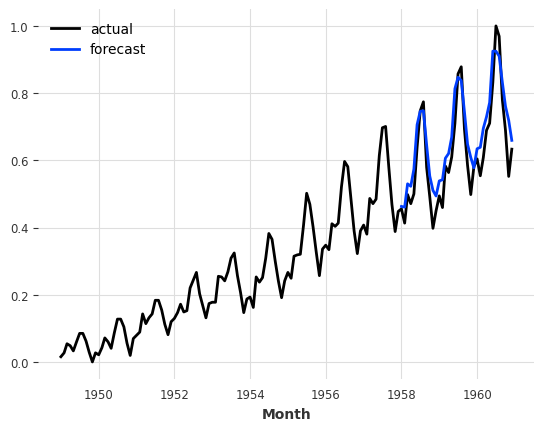

In [56]:
pred = model_air_milk.predict(n=36, series=train_air)

series_air_scaled.plot(label="actual")
pred.plot(label="forecast")
plt.legend()
print(f"MAPE = {mape(series_air_scaled, pred):.2f}%")

### Now Me

### The "LazyFetch" concept to fit multiple data files where more than one is to big for memory

Using the concept to load TimesSeries from disk.  But, this will be very I/O intensive as random indices to the sequential dataset will cause very big files to be loaded into TimeSeries objects multiple times during fit().  **Not practical.**

In [ ]:
# from collections.abc import Sequence

# class LazyFetch(Sequence):
#     def __init__(self, filenames, relative_path):
#         self._filenames = filenames
#         self._relative_path = Path(relative_path)

#     def __getitem__(self, index):
#         return self._load_file(self._filenames[index])
    
#     def __len__(self):
#         return len(self._filenames)
    
#     def _load_file(self, filename):
#         print(f"loading file {filename}")
#         if filename == "AirPassengers.csv":
#             file_path = self._relative_path / "AirPassengers.csv"
#             df = pd.read_csv(file_path, header=0, index_col="Month", parse_dates=True, dtype=np.float32)
#         elif filename == "monthly-milk.csv":
#             file_path = self._relative_path / "monthly-milk.csv"        
#             df = pd.read_csv(file_path, header=0, index_col="Month", parse_dates=True, dtype=np.float32)

#         df = df.asfreq('MS')
#         series_raw = TimeSeries.from_dataframe(df) 
#         scaler = Scaler()
#         series_scaled = scaler.fit_transform(series_raw)       
#         return series_scaled
    
# lazy_fetch = LazyFetch(["AirPassengers.csv", "monthly-milk.csv"], "../datasets")
# series = lazy_fetch[1]
# series

# To use in model fitting.
# model_air_milk.fit(series=lazy_fetch)

# But, this will be very I/O intensive as random indices to the sequential dataset will cause 
# very big files to be loaded into TimeSeries objects multiple times during fit()

# my_model.fit(series=LazyFetch)
# loading file AirPassengers.csv
# loading file monthly-milk.csv
# loading file AirPassengers.csv
# loading file monthly-milk.csv
# loading file monthly-milk.csv
# loading file AirPassengers.csv
# loading file AirPassengers.csv
# loading file monthly-milk.csv
# loading file monthly-milk.csv
# loading file monthly-milk.csv
# …


In [2]:
from darts import TimeSeries
from pathlib import Path
import pandas as pd
import random
import pickle
from sklearn.preprocessing import MinMaxScaler, StandardScaler
from pytorch_lightning.callbacks.early_stopping import EarlyStopping
from pytorch_lightning.loggers import TensorBoardLogger

#### Define some functions

In [4]:
raw_data_path = Path("../datasets")
scaled_data_path = Path("../datasets/scaled")
train_data_path = Path("../datasets/train")
val_data_path = Path("../datasets/val")
scaler_path = Path("../datasets/scalers")

def load_data_file(filename, relative_path):
    file_path = relative_path / filename
    df = pd.read_csv(file_path, header=0, index_col="Month", parse_dates=True, dtype=np.float32)
    df = df.asfreq('MS')
    series = TimeSeries.from_dataframe(df)    
    return series

def save_series_to_csv(series, filename, relative_path):
    file_path = relative_path / filename
    file_path.parent.mkdir(parents=True, exist_ok=True)    
    series.to_csv(file_path)

def create_scaler(scaler, name):
    if scaler == "MinMaxScaler":
        return Scaler(scaler=MinMaxScaler(feature_range=(0, 1)), name=name)
    elif scaler == "StandardScaler":
        return Scaler(scaler=StandardScaler(), name=name)
    
def save_scaler(scaler, filename, relative_path):
    file_path = relative_path / filename
    file_path.parent.mkdir(parents=True, exist_ok=True)    
    with open(file_path, 'wb') as f:
        pickle.dump(scaler, f)

def load_scaler(filename, relative_path):
    file_path = relative_path / filename
    with open(file_path, 'rb') as f:
        scaler = pickle.load(f)
    return scaler    


#### Load raw data files, create and fit scalars & scale the TimeSeries

In [5]:
air_series_raw = load_data_file("AirPassengers.csv", raw_data_path)
air_scaler = create_scaler("MinMaxScaler", "air")
air_scaler = air_scaler.fit(air_series_raw)
air_series_scaled = air_scaler.transform(air_series_raw)

milk_series_raw = load_data_file("monthly-milk.csv", raw_data_path)
milk_scaler = create_scaler("MinMaxScaler", "milk")
milk_scaler = milk_scaler.fit(milk_series_raw)
milk_series_scaled = milk_scaler.transform(milk_series_raw)

#### Save and load the scaled series

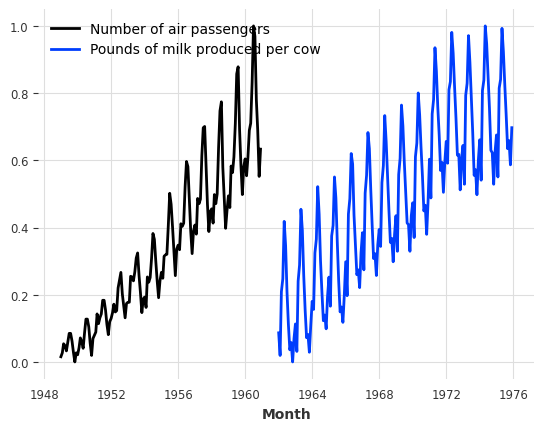

In [6]:
save_series_to_csv(air_series_scaled, "AirPassengers.csv", scaled_data_path)
save_series_to_csv(milk_series_scaled, "monthly-milk.csv", scaled_data_path)
                   
del air_series_scaled
del milk_series_scaled

air_series_scaled = load_data_file("AirPassengers.csv", scaled_data_path)
milk_series_scaled = load_data_file("monthly-milk.csv", scaled_data_path)

air_series_scaled.plot(label="Number of air passengers")
milk_series_scaled.plot(label="Pounds of milk produced per cow")
plt.legend();
plt.show()

In [7]:
air_train, air_val = air_series_scaled[:-36], air_series_scaled[-36:]
milk_train, milk_val = milk_series_scaled[:-36], milk_series_scaled[-36:]

save_series_to_csv(air_train, "air_train.csv", train_data_path)
save_series_to_csv(milk_train, "milk_train.csv", train_data_path)

<Axes: xlabel='Month'>

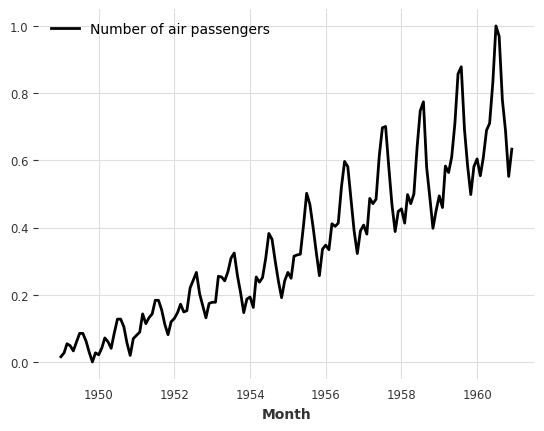

In [8]:
air_series_scaled = load_data_file("AirPassengers.csv", scaled_data_path)
air_series_scaled.plot(label="Number of air passengers")

<Axes: xlabel='Month'>

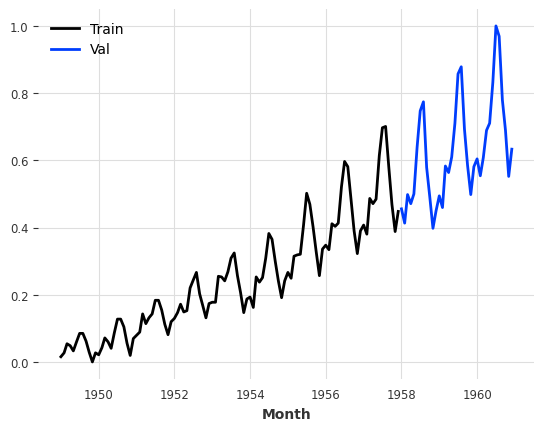

In [9]:
air_train = load_data_file("air_train.csv", train_data_path)
air_train.plot(label="Train")
air_val.plot(label="Val")

#### Emulate the DataLoader/Dataset concept as "file" DataLoader and "file" Dataset with loops over the file dataloader (outer epochs)

In [10]:
class FileDataset():
    def __init__(self, filenames, relative_path):
        self._filenames = filenames
        self._relative_path = relative_path
        self._load_counter = 0

    def __len__(self):
        return len(self._filenames)

    def __getitem__(self, idx):
        return self._load_file(self._filenames[idx])
    
    def _load_file(self, filename):
        self._load_counter += 1
        print(f"file read/file: {self._load_counter:02}-{filename}")
        file_path = self._relative_path / filename
        df = pd.read_csv(file_path, header=0, index_col="Month", parse_dates=True, dtype=np.float32)
        df = df.asfreq('MS')
        return TimeSeries.from_dataframe(df)  

    
class FileDataLoader():
    def __init__(self, dataset, shuffle=False):
        self._dataset = dataset
        self.shuffle = shuffle
        self.n_files = len(self._dataset)

    def __iter__(self):
        self._dataset_indices = list(range(self.n_files))
        if self.shuffle:
            random.shuffle(self._dataset_indices)
        self._next_idx = 0
        return self
    
    def __next__(self):
        if self._next_idx < len(self._dataset_indices):
            dataset_idx = self._dataset_indices[self._next_idx]
            self._next_idx += 1
            return self._dataset[dataset_idx]
        else:
            raise StopIteration

In [ ]:
# def generate_torch_kwargs():
#     early_stopper = EarlyStopping(
#         monitor="val_loss",
#         patience=25,
#         # min_delta=1e-5,
#         min_delta=.001,
#        mode="min",
#     )

#     # run torch models on CPU, and disable progress bars for all model stages except training.
#     return {
#         "pl_trainer_kwargs": {
#             "accelerator": "cpu",
#             "max_epochs": 5,
#             "callbacks": [TFMProgressBar(enable_train_bar_only=True), early_stopper],
#         }
#     }

In [11]:
log_dir = r"/workspaces/darts/examples/darts_logs/fit_files/logs"
sub_dir = "outer-114_inner-1_air_milk"
tensorboard_logger = TensorBoardLogger(save_dir=log_dir, name=sub_dir)

pl_trainer_kwargs = {
        "accelerator": "cpu",
        "callbacks": [TFMProgressBar(enable_train_bar_only=True)],
        "logger": tensorboard_logger,
    }


model_fit_files = NBEATSModel(
    input_chunk_length=24,
    output_chunk_length=12,
    n_epochs=40,
    batch_size=16,
    optimizer_kwargs={"lr": 1e-4},
    random_state=0,
    log_tensorboard=True,
    model_name="fit_files",    
    pl_trainer_kwargs = pl_trainer_kwargs,
)

pred_hist = air_train[-24:]

mapes = []
file_dataset = FileDataset(["milk_train.csv", "air_train.csv"], train_data_path)
file_dataloader = FileDataLoader(file_dataset, shuffle=False)
outer_epochs = 3
for outer_epoch in range(outer_epochs):
    print(f"outer_epoch: {outer_epoch+1}")
    for train_series in file_dataloader:
        model_fit_files.fit(series=train_series) #, val_series=air_val)
        # Potentially delete train_series and call the garbage collector here to free up memory

    pred = model_fit_files.predict(n=36, series=pred_hist)
    mapes.append(mape(air_val, pred))

outer_epoch: 1
file read/file: 01-milk_train.csv


Training: 0it [00:00, ?it/s]

file read/file: 02-air_train.csv


Training: 0it [00:00, ?it/s]

outer_epoch: 2
file read/file: 03-milk_train.csv


Training: 0it [00:00, ?it/s]

file read/file: 04-air_train.csv


Training: 0it [00:00, ?it/s]

outer_epoch: 3
file read/file: 05-milk_train.csv


Training: 0it [00:00, ?it/s]

file read/file: 06-air_train.csv


Training: 0it [00:00, ?it/s]

In [13]:
# finish with air, milk
file_dataset = FileDataset(["air_train.csv","milk_train.csv"], train_data_path)
file_dataloader = FileDataLoader(file_dataset, shuffle=False)
outer_epochs = 1
for outer_epoch in range(outer_epochs):
    print(f"outer_epoch: {outer_epoch+1}")
    for train_series in file_dataloader:
        model_fit_files.fit(series=train_series) #, val_series=air_val)
        # Potentially delete train_series and call the garbage collector here to free up memory

    pred = model_fit_files.predict(n=36, series=pred_hist)
    mapes.append(mape(air_val, pred))

outer_epoch: 1
file read/file: 01-air_train.csv


Training: 0it [00:00, ?it/s]

file read/file: 02-milk_train.csv


Training: 0it [00:00, ?it/s]

In [15]:
# finish again with milk, air
file_dataset = FileDataset(["milk_train.csv", "air_train.csv"], train_data_path)
file_dataloader = FileDataLoader(file_dataset, shuffle=False)
outer_epochs = 1
for outer_epoch in range(outer_epochs):
    print(f"outer_epoch: {outer_epoch+1}")
    for train_series in file_dataloader:
        model_fit_files.fit(series=train_series) #, val_series=air_val)
        # Potentially delete train_series and call the garbage collector here to free up memory

    pred = model_fit_files.predict(n=36, series=pred_hist)
    mapes.append(mape(air_val, pred))

outer_epoch: 1
file read/file: 01-milk_train.csv


Training: 0it [00:00, ?it/s]

file read/file: 02-air_train.csv


Training: 0it [00:00, ?it/s]

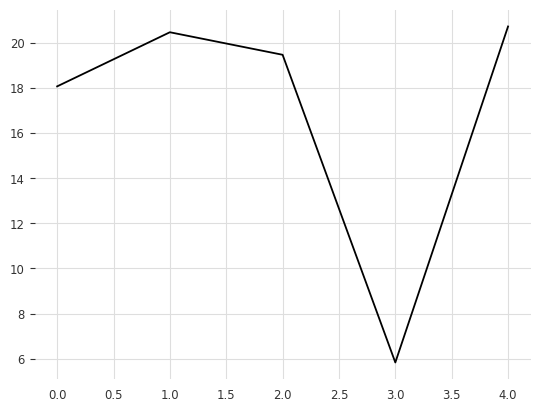

In [16]:
plt.plot(mapes) # milk, air (3, 40) batch_size=16, finish again with milk, air

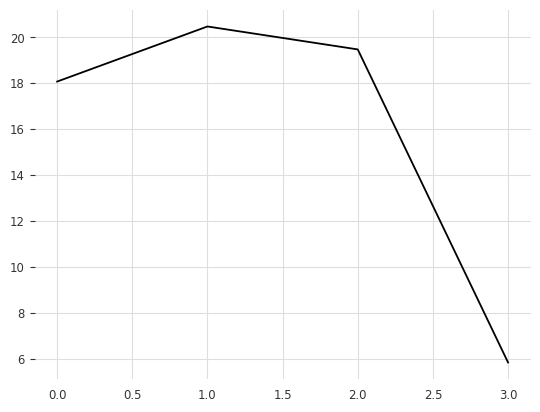

In [14]:
plt.plot(mapes) # milk, air (3, 40) batch_size=16, finish with air, milk

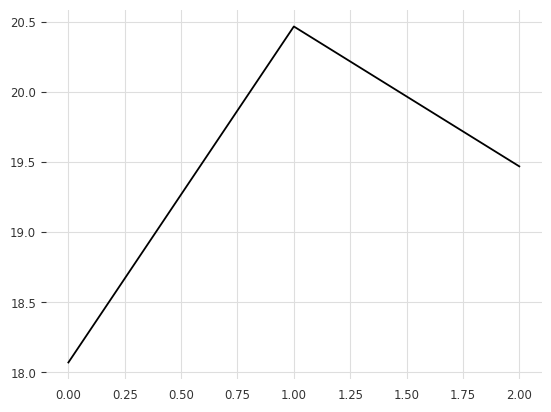

In [12]:
plt.plot(mapes) # milk, air (3, 40) batch_size=16

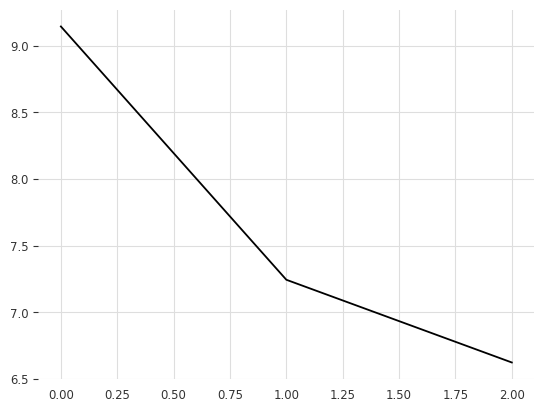

In [60]:
plt.plot(mapes) # air, milk (3, 40) batch_size=16

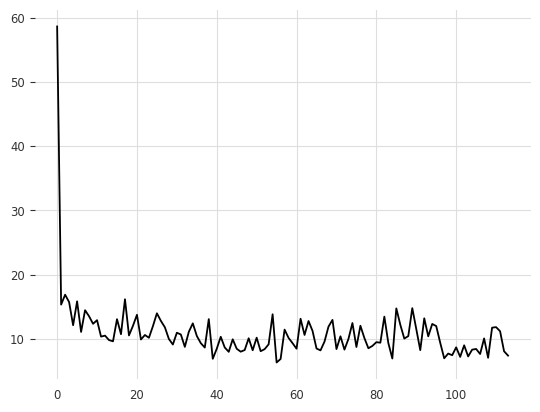

In [54]:
plt.plot(mapes) # air, milk batch_size=16

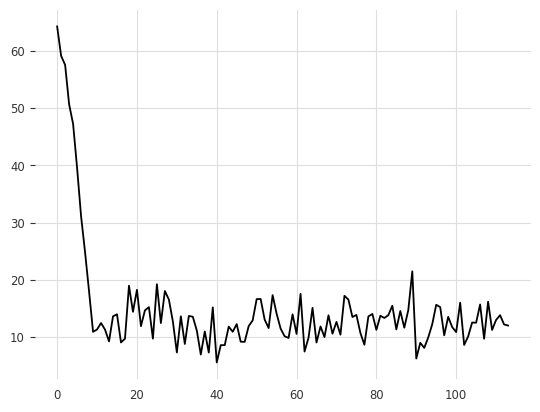

In [51]:
plt.plot(mapes) # milk, air batch_size=16

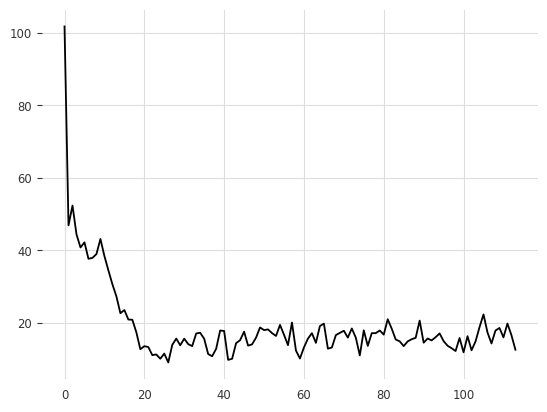

In [ ]:
plt.plot(mapes) # milk, air default batch_size

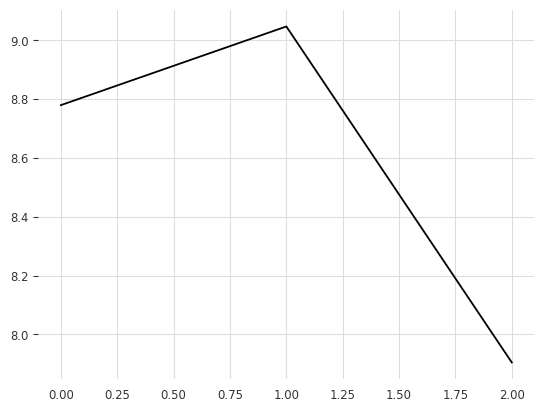

In [ ]:
# plt.plot(mapes) air, milk (3, 40) batch_size=32

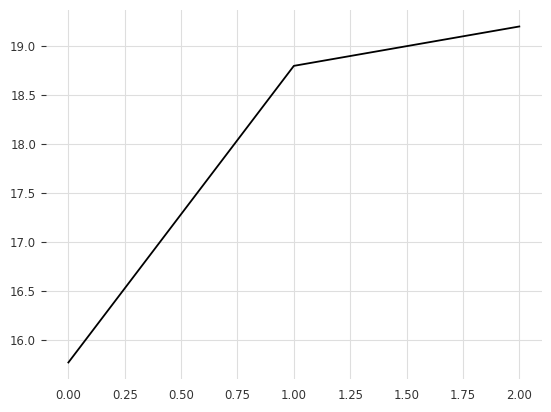

In [ ]:
plt.plot(mapes) # milk, air (3, 40) batch_size=32

In [19]:
log_dir = r"/workspaces/darts/examples/darts_logs/fit_files/logs"
sub_dir = "outer-114_inner-1_air_milk"
tensorboard_logger = TensorBoardLogger(save_dir=log_dir, name=sub_dir)

pl_trainer_kwargs = {
        "accelerator": "cpu",
        "callbacks": [TFMProgressBar(enable_train_bar_only=True)],
        "logger": tensorboard_logger,
    }


model_fit_files = NBEATSModel(
    input_chunk_length=24,
    output_chunk_length=12,
    n_epochs=20,
    batch_size=32,
    optimizer_kwargs={"lr": 1e-4},
    random_state=0,
    log_tensorboard=True,
    model_name="fit_files",    
    pl_trainer_kwargs = pl_trainer_kwargs,
)

pred_hist = air_train[-24:]

mapes = []
file_dataset = FileDataset(["milk_train.csv", "air_train.csv"], train_data_path)
file_dataloader = FileDataLoader(file_dataset, shuffle=False)
outer_epochs = 3
for outer_epoch in range(outer_epochs):
    print(f"outer_epoch: {outer_epoch+1}")
    for train_series in file_dataloader:
        model_fit_files.fit(series=train_series) #, val_series=air_val)
        # Potentially delete train_series and call the garbage collector here to free up memory

    pred = model_fit_files.predict(n=36, series=pred_hist)
    mapes.append(mape(air_val, pred))

outer_epoch: 1
file read/file: 01-milk_train.csv


Training: 0it [00:00, ?it/s]

file read/file: 02-air_train.csv


Training: 0it [00:00, ?it/s]

outer_epoch: 2
file read/file: 03-milk_train.csv


Training: 0it [00:00, ?it/s]

file read/file: 04-air_train.csv


Training: 0it [00:00, ?it/s]

outer_epoch: 3
file read/file: 05-milk_train.csv


Training: 0it [00:00, ?it/s]

file read/file: 06-air_train.csv


Training: 0it [00:00, ?it/s]

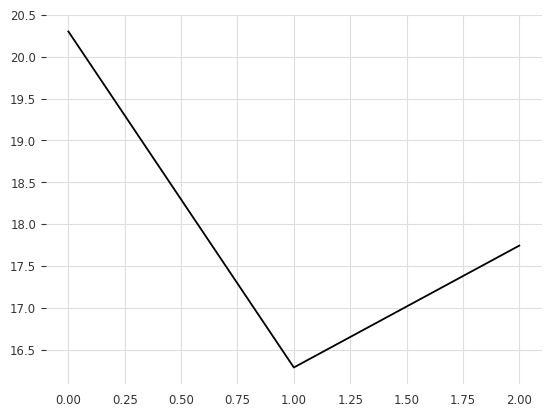

In [18]:
plt.plot(mapes) # milk, air (3, 10) batch_size=32

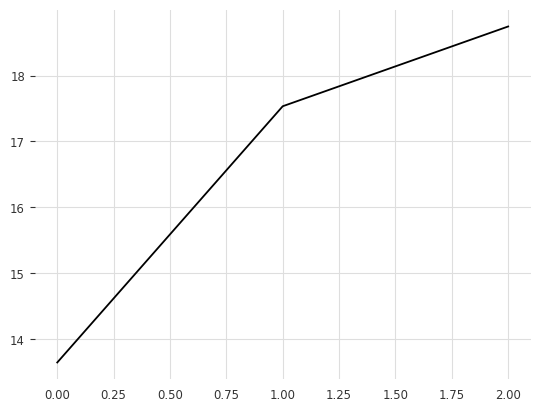

In [20]:
plt.plot(mapes) # milk, air (3, 20) batch_size=32

MAPE = 7.38%


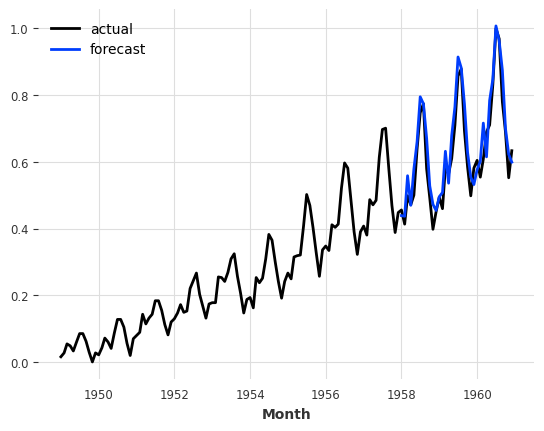

In [55]:
air_train = load_data_file("air_train.csv", train_data_path)
pred = model_fit_files.predict(n=36, series=air_train)

air_series_scaled.plot(label="actual")
pred.plot(label="forecast")
plt.legend()
print(f"MAPE = {mape(air_val, pred):.2f}%")

MAPE = 12.03%


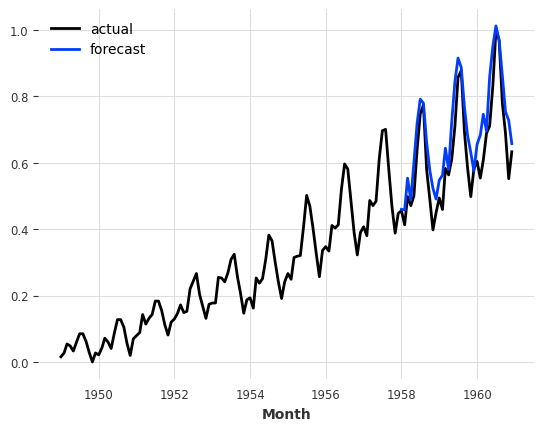

In [52]:
air_train = load_data_file("air_train.csv", train_data_path)
pred = model_fit_files.predict(n=36, series=air_train)

air_series_scaled.plot(label="actual")
pred.plot(label="forecast")
plt.legend()
print(f"MAPE = {mape(air_val, pred):.2f}%")

In [ ]:
log_dir = r"/workspaces/darts/examples/darts_logs/fit_air/logs"
sub_dir = "100_32"
tensorboard_logger = TensorBoardLogger(save_dir=log_dir, name=sub_dir)

pl_trainer_kwargs = {
        "accelerator": "cpu",
        "callbacks": [TFMProgressBar(enable_train_bar_only=True)],
        "logger": tensorboard_logger,
    }


model_fit_air = NBEATSModel(
    input_chunk_length=24,
    output_chunk_length=12,
    n_epochs=50,
    batch_size=32,
    optimizer_kwargs={"lr": 1e-3, "weight_decay": 1e-2},
    random_state=0,
    log_tensorboard=True,
    model_name="fit_air",    
    pl_trainer_kwargs = pl_trainer_kwargs,
)

model_fit_air.fit(air_train, val_series=air_val, verbose=True)

air_train = load_data_file("air_train.csv", train_data_path)
pred = model_fit_files.predict(n=36, series=air_train)

air_series_scaled.plot(label="actual")
pred.plot(label="forecast")
plt.legend()
print(f"MAPE = {mape(air_val, pred):.2f}%")

Training: 0it [00:00, ?it/s]